In [1]:
## ---- Global Cell Set Doublet Testing with Scrublet ---- 0686.01.00
## This code is new from 0686.00.00 in that is uses the downsampled
## and remixed cell set
## Load aggregated data set (previously unprocessed 10x data)
## Filter to the downsampled and remixed set (remove QC Failed cells too)
## Perform Scrublet analysis
## Save doublet scores, predicted doublets, and cell barcodes

In [2]:
import scrublet as scr

In [3]:
%matplotlib inline
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import os
import asciitable
import scipy.sparse as scp

In [4]:
## May need to run command line:
## pip install scikit-image
## May also need to run command line:
## pip install asciitable

In [5]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

In [6]:
os.getcwd()

'/gpfs/home/devans/code/CSC.Run2'

In [7]:
input_dir = '/gpfs/group/torkamani/devans/CDC2/inputdat/outs/filtered_feature_bc_matrix/unzipped'
counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + '/features.tsv', delimiter = '\t', column = 1))

print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 51981 rows, 33538 columns
Number of genes in gene list: 33538


In [8]:
## Read the downsampled and remixed cell barcodes and partition names
remix_file = "/gpfs/group/torkamani/devans/CDC2/outputdat/Remix_Codes.Noquotes.Rev1.txt"
remix_codes = np.loadtxt(remix_file, dtype={'names': ('pos', 'barcode', 'group'),'formats': ('S5', 'S20', 'S20')})
barcodes = remix_codes['barcode']
parts = remix_codes['group']

## Read the full cells set barcodes (needed for subsett)
with open(input_dir + '/barcodes.tsv') as data:
    cells = np.array(data.read().split())
print('Number of cells in cell list: {}'.format(len(cells)))

Number of cells in cell list: 51981


In [9]:
## Get the remixed cell barcodes (for the downsampled set), but remove the qc failed cells
qcpass = np.in1d(parts, np.unique(parts, return_counts=True)[0][[0, 1, 2, 4, 5, 6]])
keepers = barcodes[np.where(qcpass)]

In [10]:
## Get the index numbers of the remixed cells into the expression matrix
qcpass_down = np.in1d(cells, keepers)
keepers_ind = np.where(qcpass_down)[0]

In [11]:
## Filter the expression set to just the valid remixed downsampled cells
counts_matrix_down = counts_matrix[keepers_ind, :]
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix_down.shape[0], counts_matrix_down.shape[1]))

Counts matrix shape: 16287 rows, 33538 columns


In [17]:
## Scrublet case 2, expected rate = 10%
scrub = scr.Scrublet(counts_matrix_down, expected_doublet_rate = .10, n_neighbors = 100)

In [18]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 33.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 29.9 seconds


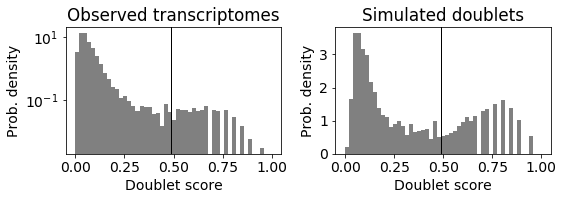

In [19]:
scrub.plot_histogram();

In [20]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

# # Uncomment to run tSNE - slow
# print('Running tSNE...')
# scrub.set_embedding('tSNE', scr.get_tsne(scrub.manifold_obs_, angle=0.9))

# # Uncomment to run force layout - slow
# print('Running ForceAtlas2...')
# scrub.set_embedding('FA', scr.get_force_layout(scrub.manifold_obs_, n_neighbors=5. n_iter=1000))
    
print('Done.')

Running UMAP...
Done.


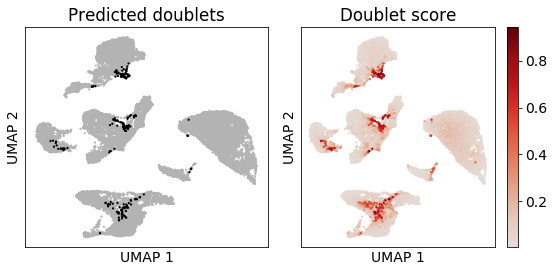

In [16]:
scrub.plot_embedding('UMAP', order_points='TRUE');

# scrub.plot_embedding('tSNE', order_points=True);
# scrub.plot_embedding('FA', order_points=True);

In [375]:
## Write the results from Scrublet
output_dir = '/gpfs/group/torkamani/devans/CDC2/outputdat/Scrublet/Rev2'
np.savetxt(output_dir + '/doublet_scores.10pct.Rev2.txt', doublet_scores)
np.savetxt(output_dir + '/predicted_doublets.10pct.Rev2.txt', predicted_doublets)

In [139]:
## Save the remixed barcodes (with and without qc failed cells)
np.savetxt(output_dir + '/remix.barcodes.10pct.Rev2.txt', barcodes, fmt='%s', delimiter = ',')
np.savetxt(output_dir + '/remix.keepers.10pct.Rev2.txt', keepers, fmt='%s', delimiter = ',')
np.savetxt(output_dir + '/remix.keepers2.10pct.Rev2.txt', cells[keepers_ind], fmt='%s', delimiter = ',')

In [142]:
print(cells[keepers_ind][0:10])
print(keepers[0:10])

['AAACGAAAGATCCCAT-1' 'AAACGAACAGGCTACC-1' 'AAACGAAGTACAAGCG-1'
 'AAACGAATCCTGCTAC-1' 'AAACGAATCTCTAAGG-1' 'AAACGCTCAACCCGCA-1'
 'AAACGCTGTCACTCTC-1' 'AAACGCTTCTACCAGA-1' 'AAAGAACAGCTTTGTG-1'
 'AAAGAACTCGGAAACG-1']
[b'AAACCCAAGTGCACCC-2' b'AAACCCACAAGTTTGC-2' b'AAACCCACATTCTCCG-2'
 b'AAACCCAGTGTGTGTT-2' b'AAACGAAAGAAGTGTT-2' b'AAACGAATCGATTCCC-2'
 b'AAACGCTAGGTTCCAT-2' b'AAACGCTGTAGCTTGT-2' b'AAACGCTGTAGTTACC-2'
 b'AAACGCTGTATAGCTC-2']


In [42]:
## Save the UMAP enbedding (x and y coordinates)
output_dir = '/gpfs/group/torkamani/devans/CDC2/outputdat/Scrublet/Rev2'
np.savetxt(output_dir + '/remix.umap.10pct.Rev2.txt', scrub._embeddings['UMAP'], fmt='%s', delimiter = ',')

In [44]:
vars(scrub)

{'_E_obs': <16287x2893 sparse matrix of type '<class 'numpy.int64'>'
 	with 4864420 stored elements in Compressed Sparse Column format>,
 '_E_sim': <32574x2893 sparse matrix of type '<class 'numpy.int64'>'
 	with 15883933 stored elements in Compressed Sparse Column format>,
 '_E_obs_norm': array([[-0.01647114, -0.11829385, -0.26121341, ...,  0.05084269,
         -0.51602702, -0.17973356],
        [-0.01647114, -0.11829385,  6.86939282, ..., -1.09006179,
          0.12057021, -0.02083409],
        [-0.01647114, -0.11829385, -0.26121341, ...,  2.32186284,
          1.34491776,  2.10130177],
        ...,
        [-0.01647114, -0.11829385, -0.26121341, ...,  0.65586604,
          1.39720718,  0.86904072],
        [-0.01647114, -0.11829385, -0.26121341, ..., -0.31750232,
         -0.82659201,  0.4440957 ],
        [-0.01647114, -0.11829385, -0.26121341, ..., -1.25567764,
         -1.26156184, -1.46570661]]),
 '_E_sim_norm': array([[-0.01647114, -0.11829385, -0.26121341, ...,  0.69474349,
  

In [19]:
dir(scrub._embeddings)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [20]:
scrub._embeddings.values()

dict_values([array([[  5.700299 , -11.620175 ],
       [  6.2276897,  -1.9180988],
       [  1.4773146, -10.364441 ],
       ...,
       [  2.639505 ,  -3.55978  ],
       [ -4.7395177,  -2.266995 ],
       [  2.7289047,   7.9106297]], dtype=float32)])

In [21]:
scrub._embeddings.keys()

dict_keys(['UMAP'])

In [22]:
umapdata = scrub._embeddings['UMAP']

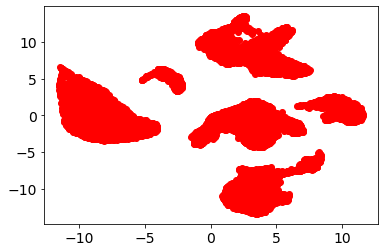

In [40]:
plt.plot(umapdata[:,0], umapdata[:,1], 'o', color = 'red')

In [47]:
Eobs = scrub._E_obs

In [96]:
np.asmatrix(Eobs)

matrix([[<16287x2893 sparse matrix of type '<class 'numpy.int64'>'
	with 4864420 stored elements in Compressed Sparse Column format>]],
       dtype=object)